Step 1: Load Libraries and Data

In [2]:
#Import packages
import numpy as np
import pandas as pd

# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("white")

In [3]:
# File paths
tsv_file = '.\\Participant_data/subject-Claudius.tsv'
log_file = '.\\Participant_data/subject-Claudius_log.txt'
csv_file = '.\\Participant_data/subject-Claudius.csv'

# Load the data
data_tsv = pd.read_csv(tsv_file, sep='\t')
data_csv = pd.read_csv(csv_file)

In [19]:


# #import CSV
# # loop to define,and append the variables into a list.
# df = []
# amt = 4 # The amount of properly labeled tsv files
# for n in range(amt):
#     #d = pd.read_csv(fr'.\\subject-{n+1}.tsv', sep='\t')
#     d = pd.read_csv(fr'.\\Participant_data/subject-Claudius.tsv', sep='\t')
#     #F-strings ('f' before the opening quotation mark) provide a way to embed variables and expressions directly within strings.  
#     df.append(d)
#     #If you want to call subject3 (df3), you can call df[3], if you want df5, call df[5], etc.
#     # Test whether data_tsv is a Pandas dataFrame
#     assert isinstance(df[n], pd.dataFrame) == True



In [20]:
# # Sample subject to visualize (you can change this)
# subject_index = 0  # For example 2, to visualize subject 3

# # Select the relevant data_tsvFrame
# data_tsv = df[subject_index]

In [21]:
#display 5 rows of 1st participant
data_tsv.head(5)

,CNT,TIME,TIME_TICK,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPOGX,...,LPUPILV,REYEX,REYEY,REYEZ,RPUPILD,RPUPILV,CX,CY,CS,USER
0,321272,2872.95166,53155120535,0.56458,0.48207,2872.22412,0.72754,7035,1,0.56734,...,1,0.03508,0.02732,0.61734,0.00344,1,0.56042,0.43519,0,STOP_TRIAL
1,321273,2872.96777,53155281757,0.56467,0.48237,2872.22412,0.74365,7035,1,0.56902,...,1,0.03508,0.02732,0.61734,0.00340,1,0.56042,0.43519,0,NaN
2,321274,2872.98535,53155455666,0.56475,0.48265,2872.22412,0.76123,7035,1,0.56902,...,1,0.03508,0.02722,0.61734,0.00342,1,0.56042,0.43519,0,START_TRIAL
3,321275,2873.00024,53155605435,0.56578,0.48345,2872.22412,0.77612,7035,1,0.55954,...,1,0.03508,0.02722,0.61734,0.00343,1,0.56042,0.43519,0,NaN
4,321276,2873.01660,53155769203,0.56543,0.48391,2872.22412,0.79248,7035,1,0.55893,...,1,0.03508,0.02722,0.61734,0.00344,1,0.56042,0.43519,0,NaN


In [22]:
data_csv.head(5)

,acc,accuracy,average_response_time,avg_rt,background,canvas_backend,central_fixation,clock_backend,color_backend,correct,...,time_welcome,title,total_correct,total_response_time,total_responses,width,x1_cor,x2_cor,y1_cor,y2_cor
0,undefined,undefined,undefined,undefined,#3d3846,legacy,True,legacy,legacy,undefined,...,819,Left-Bias-Elimination,0,0,0,1920,277,-277,-160,160
1,undefined,undefined,undefined,undefined,#3d3846,legacy,True,legacy,legacy,undefined,...,819,Left-Bias-Elimination,0,0,0,1920,277,-277,-160,160
2,undefined,undefined,undefined,undefined,#3d3846,legacy,True,legacy,legacy,undefined,...,819,Left-Bias-Elimination,0,0,0,1920,0,0,320,-320
3,undefined,undefined,undefined,undefined,#3d3846,legacy,False,legacy,legacy,undefined,...,819,Left-Bias-Elimination,0,0,0,1920,-160,160,-277,277
4,undefined,undefined,undefined,undefined,#3d3846,legacy,True,legacy,legacy,undefined,...,819,Left-Bias-Elimination,0,0,0,1920,160,-160,-277,277


Step 2: Load and Parse Log Data

In [4]:
# Load log data
with open(log_file, 'r') as file:
    log_data = file.readlines()

# Parse log data
logs = []
for line in log_data:
    if "start_trial" in line or "stop_trial" in line or "coordinates" in line:
        logs.append(line.strip())
        
# Create DataFrame for logs
log_df = pd.DataFrame(logs, columns=['log'])

# Function to extract timestamps and other details from logs
def extract_log_details(log_df):
    events = []
    for index, row in log_df.iterrows():
        if "start_trial" in row['log']:
            events.append({'timestamp': index, 'event': 'start_trial'})
        elif "stop_trial" in row['log']:
            events.append({'timestamp': index, 'event': 'stop_trial'})
        elif "coordinates" in row['log']:
            coords = row['log'].split(':')[1].strip()
            events.append({'timestamp': index, 'event': 'coordinates', 'coords': coords})
    return pd.DataFrame(events)

# Extracting log details
log_events = extract_log_details(log_df)
log_events.head()

,timestamp,event,coords
0,0,start_trial,NaN
1,1,coordinates,"(277,-160, -277, 160)"
2,2,stop_trial,NaN
3,3,start_trial,NaN
4,4,coordinates,"(277,-160, -277, 160)"


Step 3: Different Plots

Step 3.1: Distribution of FPOGX

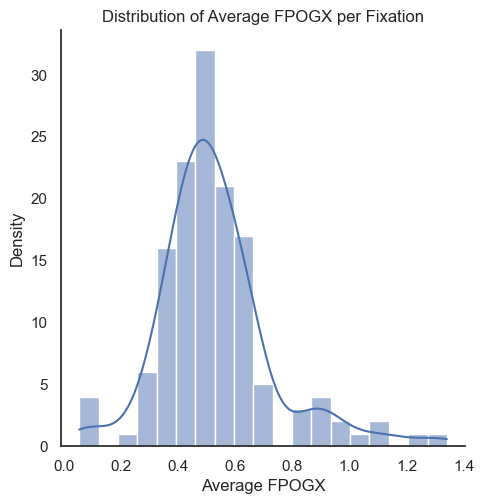

In [5]:
df_fixations = data_tsv.groupby('FPOGID')['FPOGX'].mean().reset_index()

# Plot the distribution using seaborn's displot
sns.displot(df_fixations, x='FPOGX', kde=True) 
plt.title('Distribution of Average FPOGX per Fixation')
plt.xlabel('Average FPOGX')
plt.ylabel('Density')
plt.show()

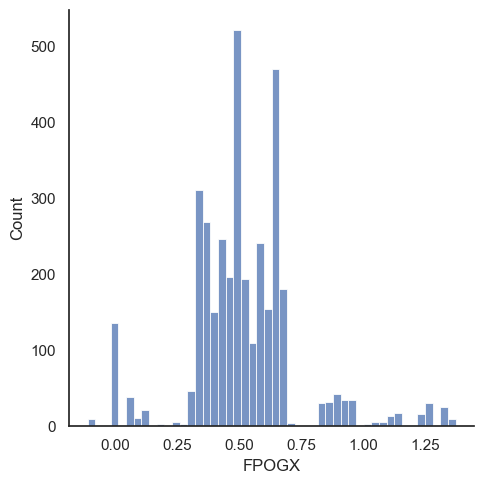

In [6]:
#test the dataset with a displot
#Use FPOGID instead of count to get Valid Counts (One fixation gets many counts)
sns.displot(data_tsv, x='FPOGX')

Step 3.2: Plot Time Against X-Position with Vertical Lines for Each User Log/Trigger

In [ ]:
# Filter the data_tsv for different event types
fixation_points = data_tsv[data_tsv['USER'] == 'FIXATION']
start_trial_points = data_tsv[data_tsv['USER'] == 'START_TRIAL']
stop_trial_points = data_tsv[data_tsv['USER'] == 'STOP_TRIAL']
stimuli_points = data_tsv[data_tsv['USER'] == 'STIMULI']
coordinates_points = data_tsv[data_tsv['USER'] == 'COORDINATES']

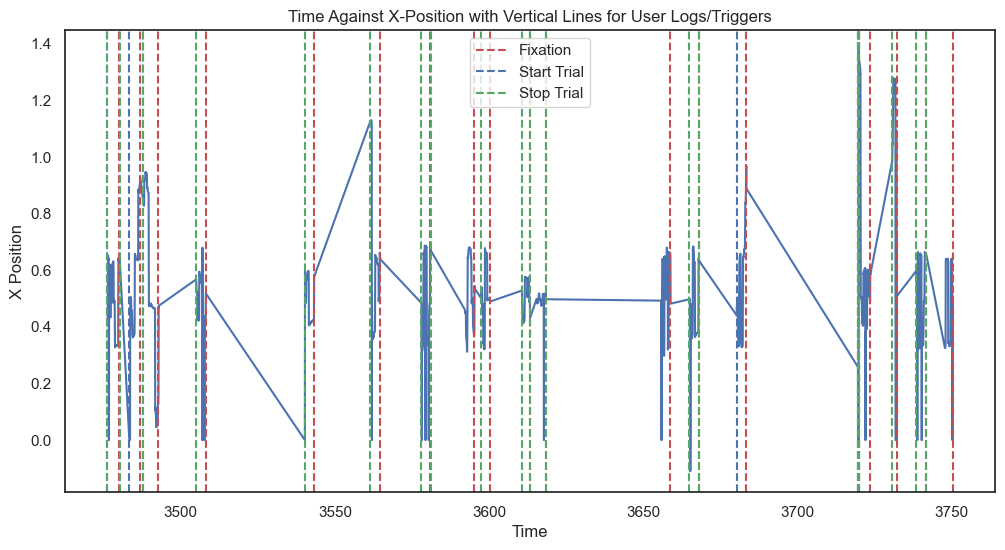

In [29]:

# **Time vs. X Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("X Position")
#plt.xlim(3500, 3600)

# Filter the data_tsv for different event types
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION']['TIME']
start_trial_times = data_tsv[data_tsv['USER'] == 'START_TRIAL']['TIME']
stop_trial_times = data_tsv[data_tsv['USER'] == 'STOP_TRIAL']['TIME']
stimuli_times = data_tsv[data_tsv['USER'] == 'STIMULI']['TIME']
coordinates_times = data_tsv[data_tsv['USER'] == 'COORDINATES']['TIME']

# Add vertical lines for each event type
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--', label='Fixation' if fixation_time == fixation_times.iloc[0] else "")
for start_trial_time in start_trial_times:
    plt.axvline(x=start_trial_time, color='b', linestyle='--', label='Start Trial' if start_trial_time == start_trial_times.iloc[0] else "")
for stop_trial_time in stop_trial_times:
    plt.axvline(x=stop_trial_time, color='g', linestyle='--', label='Stop Trial' if stop_trial_time == stop_trial_times.iloc[0] else "")
for stimuli_time in stimuli_times:
    plt.axvline(x=stimuli_time, color='m', linestyle='--', label='Stimuli' if stimuli_time == stimuli_times.iloc[0] else "")
for coordinates_time in coordinates_times:
    plt.axvline(x=coordinates_time, color='y', linestyle='--', label='Coordinates' if coordinates_time == coordinates_times.iloc[0] else "")

# Add a legend
plt.legend()

plt.show()


In [8]:
# # **Time vs. X Plot**
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
# plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
# plt.xlabel("Time")
# plt.ylabel("X Position")

# # Add vertical lines for each user log/trigger
# for trigger_time in data_csv['time_image_stimulus']:
#  plt.axvline(x=trigger_time, color='r', linestyle='--')
# plt.show()

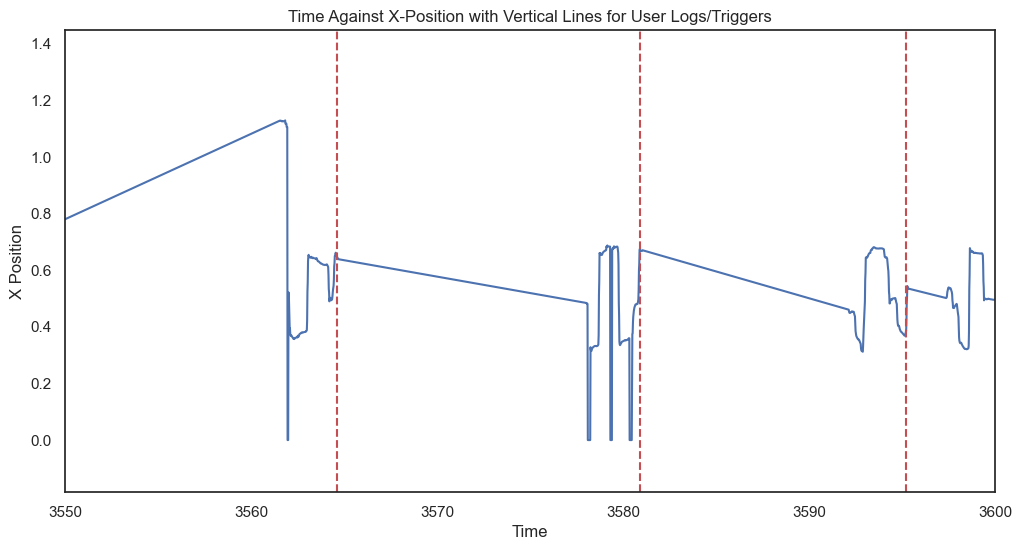

In [9]:
# **Time vs. X Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("X Position")
plt.xlim(3550, 3600)
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

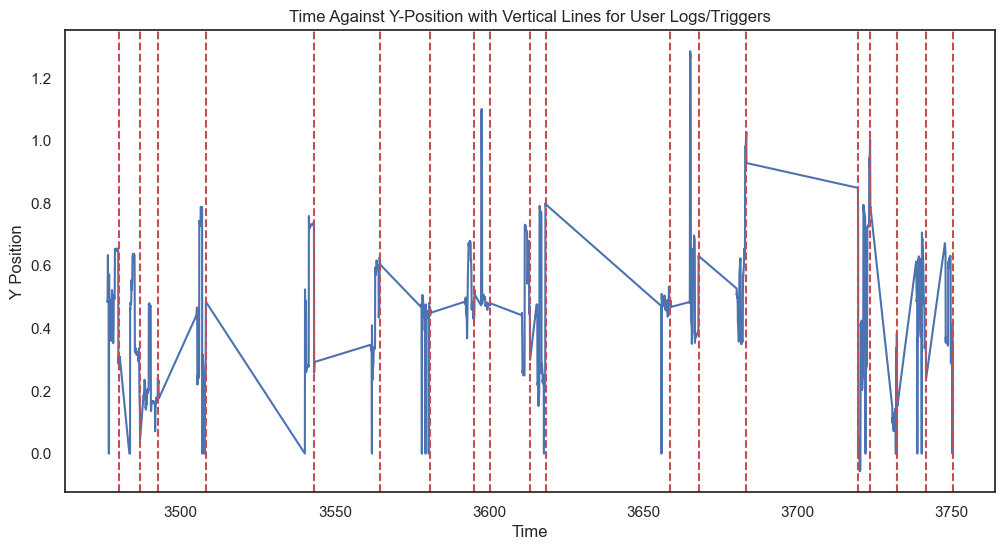

In [13]:
# **Time vs. Y Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
plt.title('Time Against Y-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("Y Position")
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

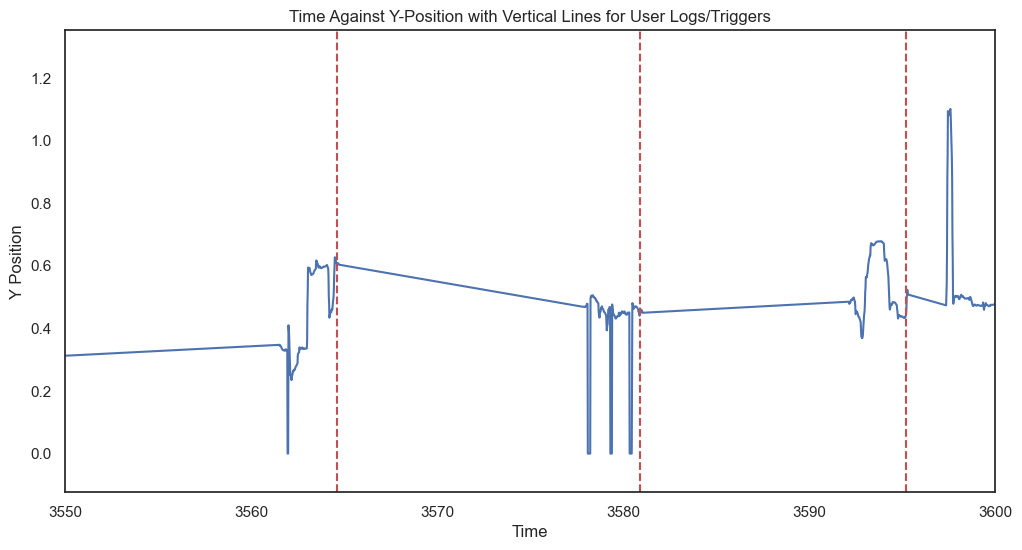

In [12]:
# **Time vs. Y Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
plt.title('Time Against Y-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("Y Position")
plt.xlim(3550, 3600)
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

In [14]:
# # **Time vs. Y Plot** zoom in
# sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
# # Zoom in on the x-axis between 0.6 and 0.7
# plt.xlim(3550, 3600)
# plt.title(f"Subject {subject_index + 1} - Y Position over Time")
# plt.xlabel("Time")
# plt.ylabel("Y Position")
# plt.show()

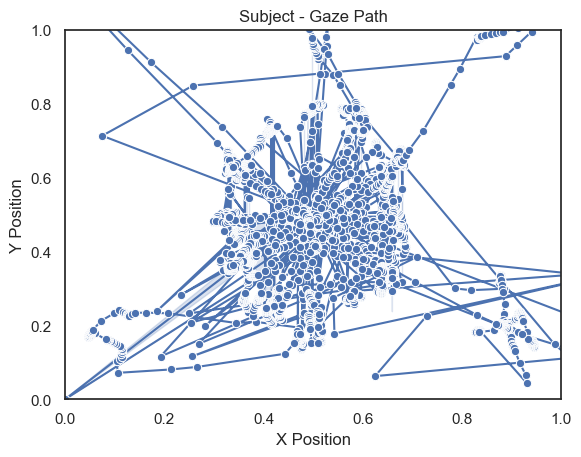

In [25]:
# **X vs. Y Plot (Gaze Path)**
#sns.scatterplot(data_tsv=data_tsv, x="FPOGX", y="FPOGY", s=40, hue='FPOGID')  # Use scatterplot for gaze path
sns.lineplot(data=data_tsv, x="FPOGX", y="FPOGY", marker='o', sort =False)  # Use scatterplot for gaze path
# Zoom in on the x-axis between 0.6 and 0.7

plt.title(f"Subject - Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


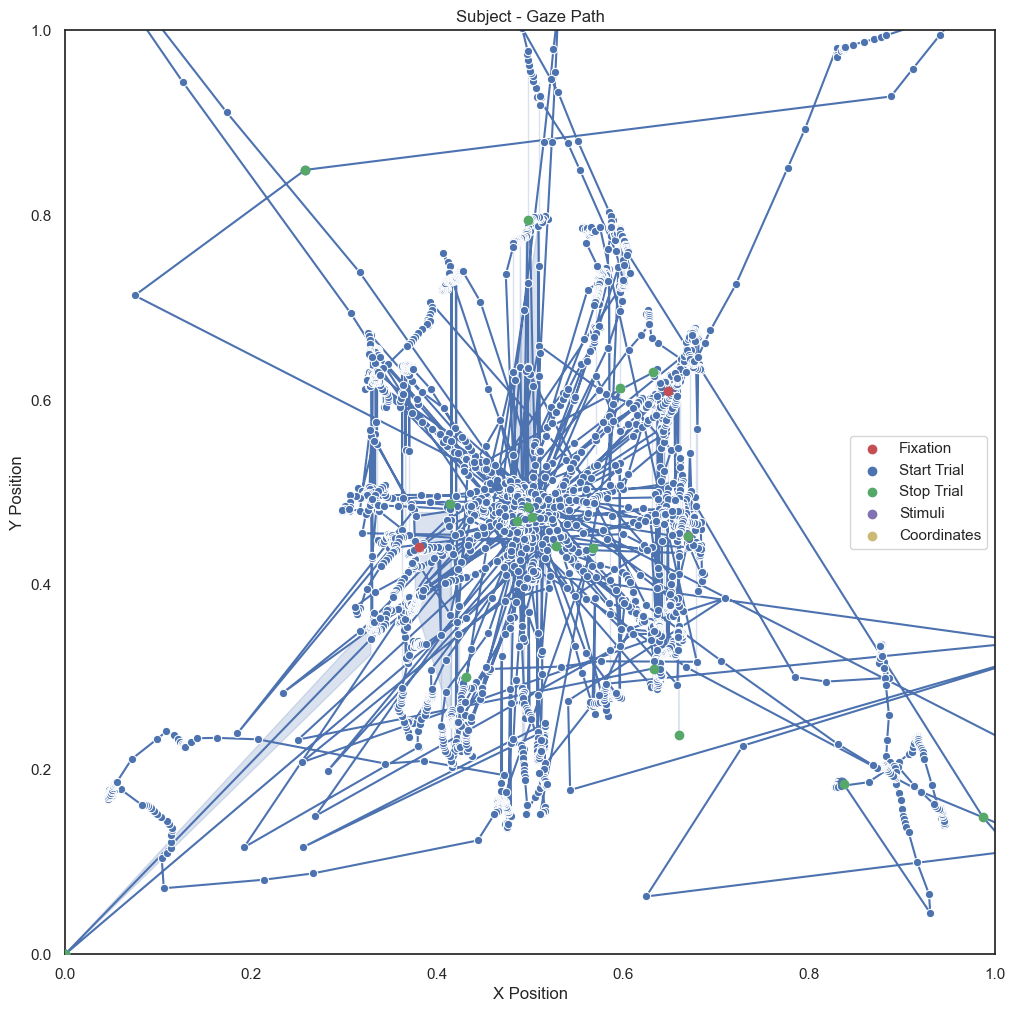

In [49]:


# **X vs. Y Plot (Gaze Path)**
plt.figure(figsize=(12, 12))
sns.lineplot(data=data_tsv, x="FPOGX", y="FPOGY", marker='o', sort=False)

# Add scatter plots for different event types
plt.scatter(fixation_points["FPOGX"], fixation_points["FPOGY"], color='r', label='Fixation', zorder=5)
plt.scatter(start_trial_points["FPOGX"], start_trial_points["FPOGY"], color='b', label='Start Trial', zorder=6)
plt.scatter(stop_trial_points["FPOGX"], stop_trial_points["FPOGY"], color='g', label='Stop Trial', zorder=7)
plt.scatter(stimuli_points["FPOGX"], stimuli_points["FPOGY"], color='m', label='Stimuli', zorder=8)
plt.scatter(coordinates_points["FPOGX"], coordinates_points["FPOGY"], color='y', label='Coordinates', zorder=9)

plt.title(f"Subject - Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()


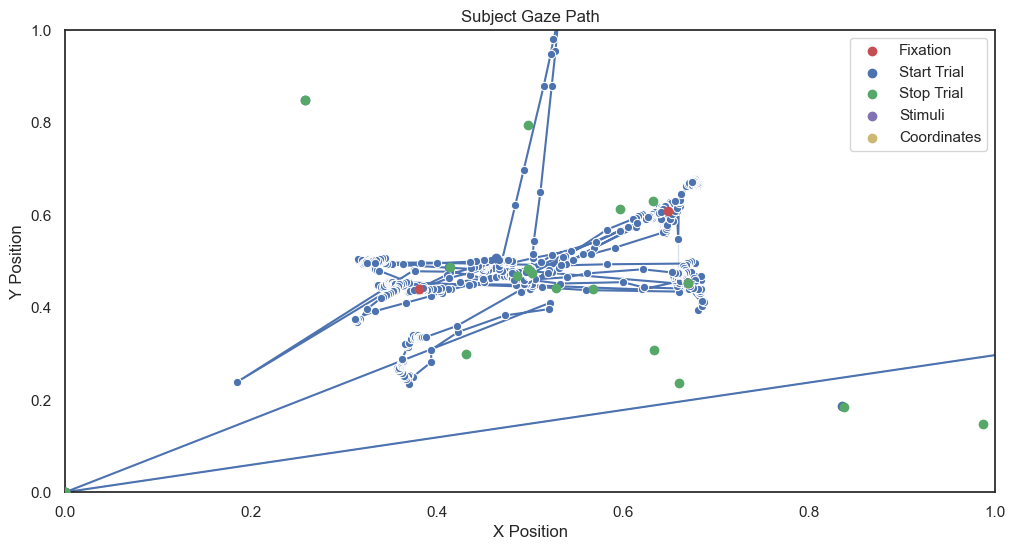

In [30]:
# Filter the data_tsv for the specified time range
filtered_data = data_tsv[(data_tsv['TIME'] >= 3550) & (data_tsv['TIME'] <= 3600)]

# Filter the data_tsv for fixation points within the specified time range
fixation_points = filtered_data[filtered_data['USER'] == 'FIXATION']

# **X vs. Y Plot (Gaze Path)**
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="FPOGX", y="FPOGY", marker='o', sort=False)

# Add scatter plots for different event types
plt.scatter(fixation_points["FPOGX"], fixation_points["FPOGY"], color='r', label='Fixation', zorder=5)
plt.scatter(start_trial_points["FPOGX"], start_trial_points["FPOGY"], color='b', label='Start Trial', zorder=6)
plt.scatter(stop_trial_points["FPOGX"], stop_trial_points["FPOGY"], color='g', label='Stop Trial', zorder=7)
plt.scatter(stimuli_points["FPOGX"], stimuli_points["FPOGY"], color='m', label='Stimuli', zorder=8)
plt.scatter(coordinates_points["FPOGX"], coordinates_points["FPOGY"], color='y', label='Coordinates', zorder=9)

plt.title(f"Subject Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()


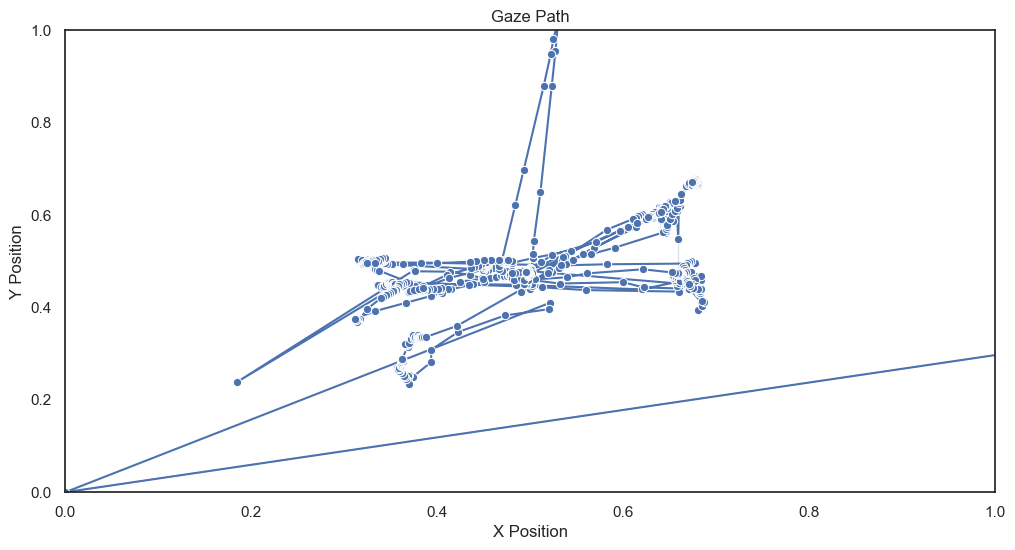

In [23]:
# Filter the data_tsv for the specified time range
filtered_data = data_tsv[(data_tsv['TIME'] >= 3550) & (data_tsv['TIME'] <= 3600)]

# **X vs. Y Plot (Gaze Path)**
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="FPOGX", y="FPOGY", marker='o', sort=False)
plt.title("Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


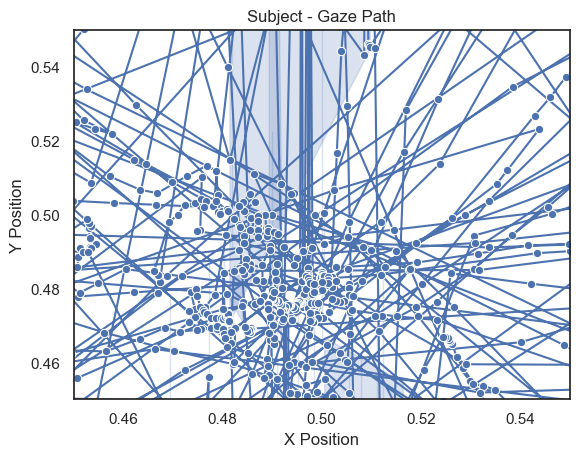

In [24]:
# **X vs. Y Plot (Gaze Path)**
#sns.scatterplot(data_tsv=data_tsv, x="FPOGX", y="FPOGY", s=40, hue='FPOGID')  # Use scatterplot for gaze path
sns.lineplot(data=data_tsv, x="FPOGX", y="FPOGY", marker='o', sort =False)  # Use scatterplot for gaze path
# Zoom in on the x- and y-axis
plt.xlim(0.45, 0.55)
plt.ylim(0.45, 0.55)
plt.title(f"Subject - Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()


Step 4: Check for Balancing/Randomization Errors

In [44]:
def check_balancing_errors(data_tsv):
    # Count the occurrences of each unique value in the 'USER' column
    
    event_counts = data_tsv['USER'].value_counts()
    print("Event frequency in the 'USER' column:")
    print(event_counts)
    
    print()  # Add a blank line for better readability

check_balancing_errors(data_tsv)


Event frequency in the 'USER' column:
USER
STOP_TRIAL                           20
FIXATION                             19
START_TRIAL                           7
STOP_TRIAL LOG                        6
COORDINATES:(-160,277, 160, -277)     5
STIMULI: (002.PNG, 010.PNG)           2
COORDINATES:(0,320, 0, -320)          2
STIMULI: (010.PNG, 000.PNG)           2
STIMULI: (001.PNG, 003.PNG)           1
COORDINATES:(277,160, -277, -160)     1
COORDINATES:(320,0, -320, 0)          1
COORDINATES:(0,-320, 0, 320)          1
STIMULI: (009.PNG, 006.PNG)           1
STIMULI: (008.PNG, 009.PNG)           1
STIMULI: (000.PNG, 008.PNG)           1
STIMULI: (005.PNG, 005.PNG)           1
COORDINATES:(-320,0, 320, 0)          1
COORDINATES:(-160,-277, 160, 277)     1
STIMULI: (011.PNG, 007.PNG)           1
STIMULI: (007.PNG, 001.PNG)           1
STIMULI: (004.PNG, 004.PNG)           1
COORDINATES:(277,-160, -277, 160)     1
COORDINATES:(-277,160, 277, -160)     1
Name: count, dtype: int64



Step 5: Calculate Accuracy/Precision while Gaze is on a Fixation-Cross

In [48]:
def calculate_accuracy_precision(data_tsv):
    fixation_cross_coords = (0, 0)  # Assuming fixation cross is at the center
    
    # Filter data for fixation events of USER column with FIXATION value
    fixation_data = data_tsv[(data_tsv['USER'] == 'FIXATION')]
    
    # Calculate distances from fixation cross
    fixation_distances = np.sqrt((fixation_data['FPOGX'] - fixation_cross_coords[0])**2 + 
                                 (fixation_data['FPOGY'] - fixation_cross_coords[1])**2)
    
    accuracy = fixation_distances.mean()
    precision = fixation_distances.std()   
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")

# Assuming data_tsv is already defined and contains necessary columns
# Example call:
calculate_accuracy_precision(data_tsv)


Accuracy: 0.6893049848511442
Precision: 0.33894082271327375
